## Кластеризация. Домашнее задание
### Данные
В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (10, 6)

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [2]:
geo = pd.read_excel(r'10_Кластеризация\geo.xlsx')
geo.head()

,Unnamed: 0,x,y,comment_class
0,0,37.612416,55.777454,-1
1,1,37.612416,55.777454,-1
2,2,37.603298,55.742108,-1
3,3,37.558526,55.728758,-1
4,4,37.566431,55.731794,-1


In [3]:
geo.drop('Unnamed: 0', axis = 1, inplace = True)

In [4]:
geo.head()

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


In [14]:
geo.describe()

,x,y,comment_class
count,108806.000000,108806.000000,108806.000000
mean,37.567532,55.766346,-0.748929
std,0.121996,0.069622,0.662653
min,37.148813,55.496939,-1.000000
25%,37.454528,55.729797,-1.000000
50%,37.559640,55.764734,-1.000000
75%,37.684784,55.806869,-1.000000
max,37.931228,55.994174,1.000000


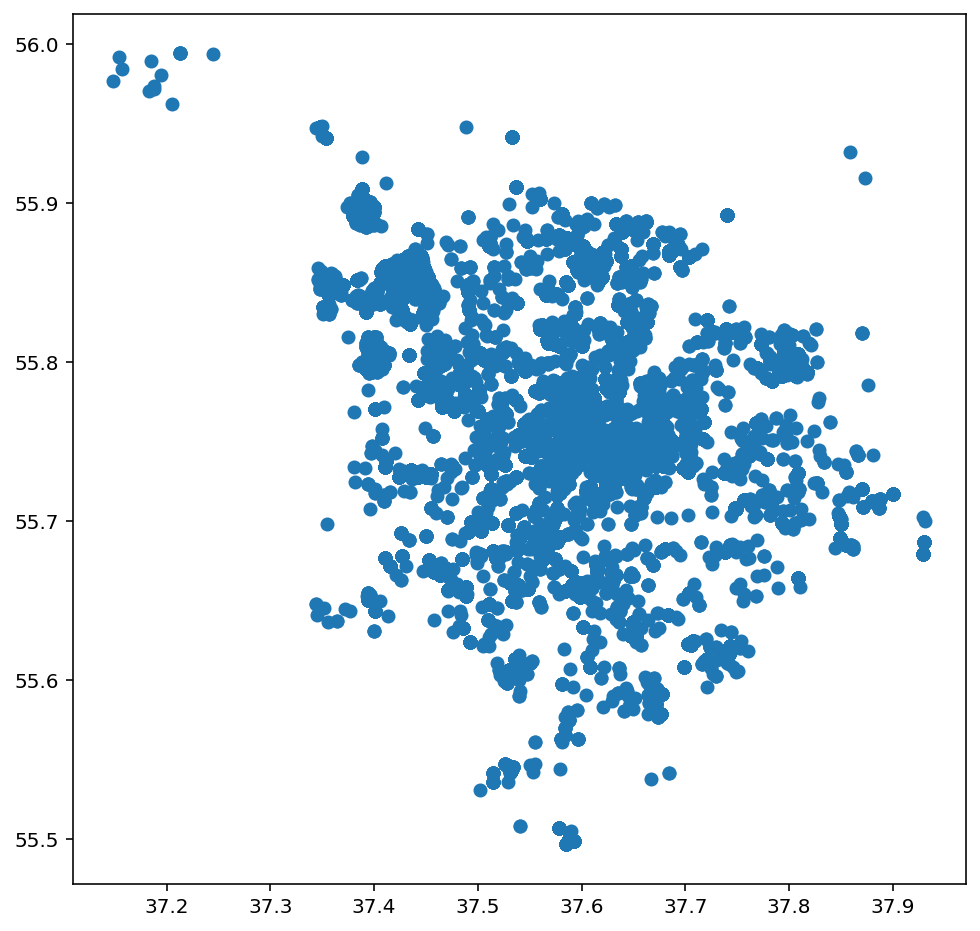

In [6]:
# Выведем все координаты
plt.figure(figsize=[8,8])
plt.scatter(geo.x, geo.y)

Видно, что по общему распределению голосов нельзя сделать выводы о количестве кластеров

### KMeans

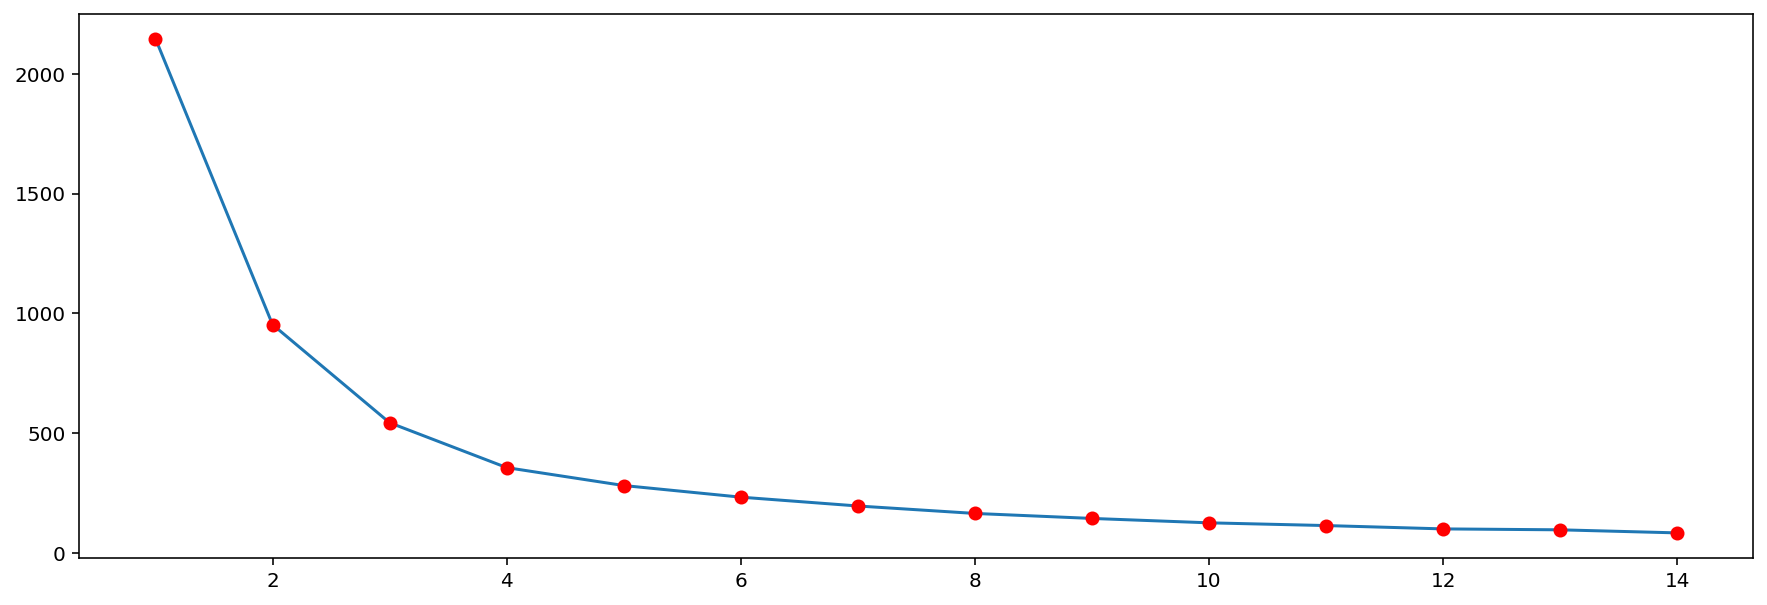

In [7]:
# Определим оптимальное число кластеров с помощью графика локтя.
k_inertia = []
ks = range(1, 15)

for k in ks:
    c_kmeans = KMeans(n_clusters = k)
    clusters_kmeans = c_kmeans.fit_predict(geo[['x', 'y']])
    k_inertia.append(c_kmeans.inertia_)
    
plt.figure(figsize = [15,5])    
plt.plot(ks, k_inertia)
plt.plot(ks, k_inertia ,'ro')

График показывает, что оптимальное количество кластеров 4, так как при большем значении кластеров качество разбиения перестаёт резко улучшаться. 

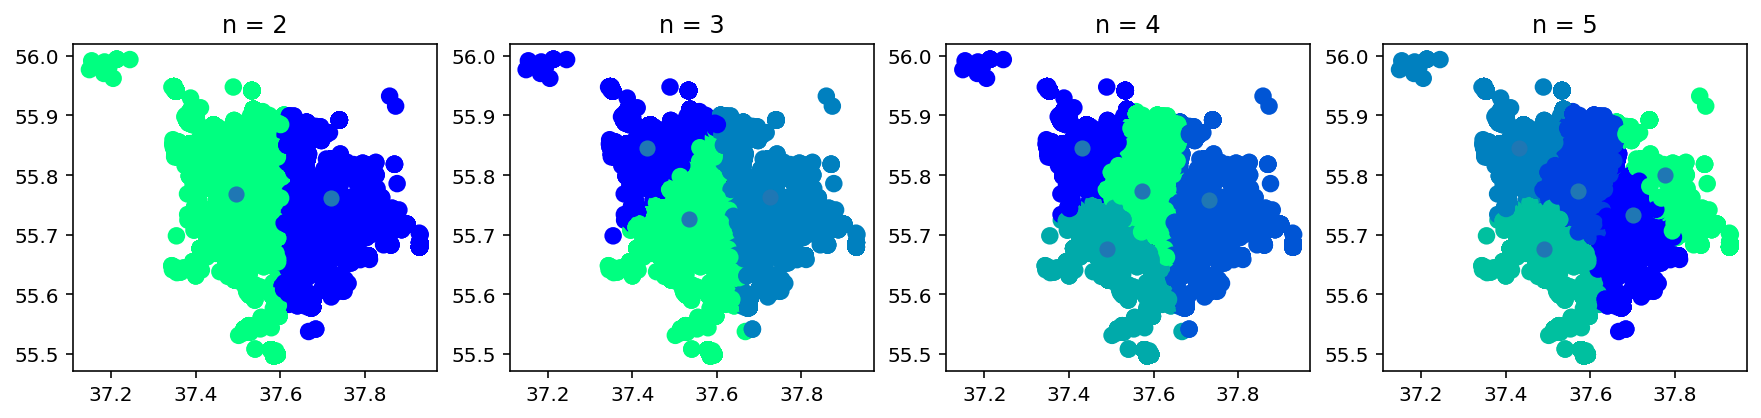

In [10]:
sizes = [2, 3, 4, 5]
fig, axes = plt.subplots(1, 4, figsize = (15, 3))
for ax, i in zip(axes, sizes):
    kmeans = KMeans(n_clusters = i)
    clusters = kmeans.fit_predict(geo[['x', 'y']])
    ax.scatter(geo.x, geo.y, c = clusters, cmap = 'winter', s = 60)
    ax.set_title('n = {}'.format(i))
    centers = kmeans.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1], s = 50)

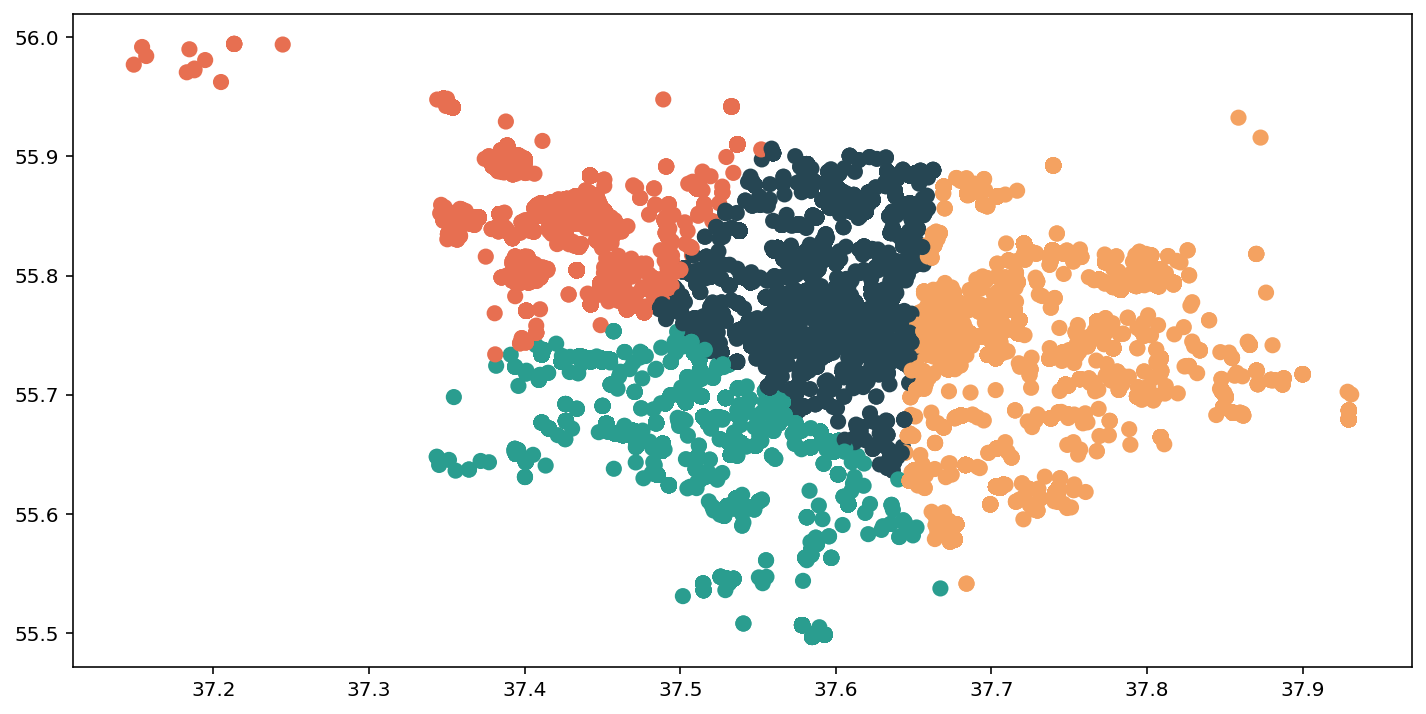

In [15]:
# пусть количество кластеров будет = 4
fig, ax = plt.subplots(figsize=(12, 6))
num_cluster = 4
k_means = KMeans(init = 'k-means++', n_clusters = num_cluster, max_iter = 100, random_state = 30)
k_means.fit(X)
clusters_district = k_means.labels_
LABEL_COLOR_MAP = {0 : '#264653', # черные
                   1 : '#2a9d8f', # зеленые
                   2 : '#f4a261', # оранжевые
                   3 : '#e76f51', # красные
                  }
label_color = [LABEL_COLOR_MAP[l] for l in clusters_district]
ax.scatter(X[:, 0], X[:, 1], c=label_color, s=50)

In [16]:
# посмотрим, как распределилось соотношение проголосовавших за и против по кластерам
# добавим полученные метки кластеров для каждого наблюдения
geo['cluster_district'] = clusters_district

geo_dum = pd.get_dummies(geo['comment_class'])
geo_dum.columns

Int64Index([-1, 1], dtype='int64')

In [19]:
geo['protiv'] = geo_dum[-1]

In [20]:
geo['za'] = geo_dum[1]

In [21]:
pivot_geo = geo.groupby('cluster_district').agg({'protiv' : 'sum', 'za' : 'sum'})
pivot_geo

,protiv,za
cluster_district,,
0,23329.0,5524.0
1,22250.0,207.0
2,26274.0,4903.0
3,23294.0,3025.0


In [28]:
pivot_geo['za%'] = pivot_geo['za'] / (pivot_geo['protiv'] + pivot_geo['za']) * 100

In [30]:
# видим, что высокие доли людей, проголосовавших за, находится в районах 0 (19%) и 2 (15%)
# в районе 1 доля проголосовавших самая низкая - менее 1%
pivot_geo

,protiv,za,za%
cluster_district,,,
0,23329.0,5524.0,19.145323
1,22250.0,207.0,0.921762
2,26274.0,4903.0,15.726337
3,23294.0,3025.0,11.493598
